<a href="https://colab.research.google.com/github/mralamdari/Machine_Learning_Projects/blob/main/Video_Processing_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import PIL
import cv2
import tqdm
import copy
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

#Dataset
[HMDB](https:/​/​serre-​lab.​clps.brown.​edu/​resource/​hmdb-​a-​large-​human-​motion-​database/​#overview): a large human motion database with 7000 clips in 51 action classes and 2 GB size

In [ ]:
!wget https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar

In [ ]:
!pip install patool
import patoolib
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/data/hmdb51_org/', exist_ok=True)
patoolib.extract_archive("hmdb51_org.rar", outdir="/content/data/hmdb51_org/")

In [ ]:
sub_folder = "hmdb51_org"
sub_folder_jpg = "hmdb51_jpg"
rar_names = os.listdir('/content/data/hmdb51_org')
os.remove("/content/hmdb51_org.rar")
for dir in rar_names:
  patoolib.extract_archive(f"/content/data/hmdb51_org/{dir}", outdir="/content/data/hmdb51_org/")
  os.remove(f"/content/data/hmdb51_org/{dir}")

In [ ]:
path2data = '/content/data/'
path2cat = '/content/data/hmdb51_org'
categories = os.listdir(path2cat)
print(len(categories))
categories

51


['run',
 'clap',
 'handstand',
 'brush_hair',
 'golf',
 'pick',
 'wave',
 'flic_flac',
 'punch',
 'laugh',
 'chew',
 'situp',
 'shoot_gun',
 'ride_bike',
 'eat',
 'draw_sword',
 'somersault',
 'dive',
 'climb_stairs',
 'pullup',
 'sword_exercise',
 'smile',
 'dribble',
 'catch',
 'shake_hands',
 'drink',
 'stand',
 'kick_ball',
 'pour',
 'pushup',
 'hug',
 'climb',
 'smoke',
 'jump',
 'walk',
 'ride_horse',
 'shoot_ball',
 'hit',
 'push',
 'fencing',
 'shoot_bow',
 'cartwheel',
 'swing_baseball',
 'fall_floor',
 'sit',
 'turn',
 'throw',
 'kick',
 'talk',
 'kiss',
 'sword']

In [ ]:
for cat in categories:
  videos = os.listdir(f'{path2cat}/{cat}')
  print(cat, len(videos))

run 232
clap 130
handstand 113
brush_hair 107
golf 105
pick 106
wave 104
flic_flac 107
punch 126
laugh 128
chew 109
situp 105
shoot_gun 103
ride_bike 103
eat 108
draw_sword 103
somersault 140
dive 127
climb_stairs 112
pullup 104
sword_exercise 127
smile 102
dribble 145
catch 102
shake_hands 162
drink 164
stand 154
kick_ball 128
pour 106
pushup 103
hug 118
climb 108
smoke 109
jump 151
walk 548
ride_horse 116
shoot_ball 131
hit 127
push 116
fencing 116
shoot_bow 112
cartwheel 107
swing_baseball 143
fall_floor 136
sit 142
turn 240
throw 102
kick 130
talk 120
kiss 102
sword 127


In [ ]:
def get_vids(path2ajpgs):
    listOfCats = os.listdir(path2ajpgs)
    ids = []
    labels = []
    for catg in listOfCats:
        path2catg = os.path.join(path2ajpgs, catg)
        listOfSubCats = os.listdir(path2catg)
        path2subCats= [os.path.join(path2catg,los) for los in listOfSubCats]
        ids.extend(path2subCats)
        labels.extend([catg]*len(listOfSubCats))
    return ids, labels, listOfCats 

In [ ]:
def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)
    
    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()
    return frames, v_len

def store_frames(frames, path2store):
    for i, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = f"{path2store}/frame{i}.jpg"
        cv2.imwrite(path2img, frame)

In [ ]:
extension = '.avi'
n_frames = 16
for root, dirs, files in os.walk(path2cat, topdown=False):
  for name in files:
    if extension not in name:
      continue
    path2vid = os.path.join(root, name)
    frames, vlen = get_frames(path2vid, n_frames=n_frames)
    path2store = path2vid.replace(sub_folder, sub_folder_jpg)
    path2store = path2store.replace(extension, '')
    os.makedirs(path2store, exist_ok=True)
    store_frames(frames, path2store)

In [ ]:
path2data = '/content/data/'
path2ajpgs = os.path.join(path2data, sub_folder_jpg)
all_vids, all_labels, catgs = get_vids(path2ajpgs)
len(all_vids), len(all_labels), len(catgs)

(6766, 6766, 51)

In [ ]:
all_vids[:3], all_labels[:3], catgs[:3]

(['/content/data/hmdb51_jpg/run/The_Matrix_6_run_f_cm_np1_fr_med_2',
  '/content/data/hmdb51_jpg/run/The_Fugitive_2_run_f_nm_np3_fr_med_15',
  '/content/data/hmdb51_jpg/run/Two_Towers_1_run_u_cm_np2_fr_bad_6'],
 ['run', 'run', 'run'],
 ['run', 'clap', 'handstand'])

In [ ]:
labels_dict = {}
ind = 0
for u in catgs:
  labels_dict[u] = ind
  ind += 1

labels_dict

{'brush_hair': 3,
 'cartwheel': 41,
 'catch': 23,
 'chew': 10,
 'clap': 1,
 'climb': 31,
 'climb_stairs': 18,
 'dive': 17,
 'draw_sword': 15,
 'dribble': 22,
 'drink': 25,
 'eat': 14,
 'fall_floor': 43,
 'fencing': 39,
 'flic_flac': 7,
 'golf': 4,
 'handstand': 2,
 'hit': 37,
 'hug': 30,
 'jump': 33,
 'kick': 47,
 'kick_ball': 27,
 'kiss': 49,
 'laugh': 9,
 'pick': 5,
 'pour': 28,
 'pullup': 19,
 'punch': 8,
 'push': 38,
 'pushup': 29,
 'ride_bike': 13,
 'ride_horse': 35,
 'run': 0,
 'shake_hands': 24,
 'shoot_ball': 36,
 'shoot_bow': 40,
 'shoot_gun': 12,
 'sit': 44,
 'situp': 11,
 'smile': 21,
 'smoke': 32,
 'somersault': 16,
 'stand': 26,
 'swing_baseball': 42,
 'sword': 50,
 'sword_exercise': 20,
 'talk': 48,
 'throw': 46,
 'turn': 45,
 'walk': 34,
 'wave': 6}

In [ ]:
num_classes = 5

unique_ids, unique_labels = [], []
for id, label in zip(all_vids, all_labels):
  if labels_dict[label] < num_classes:
    unique_ids.append(id) 
    unique_labels.append(label)  

In [ ]:
len(unique_ids), len(unique_labels)

(687, 687)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=24)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]

print(len(train_ids), len(train_labels))

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]

print(len(test_ids), len(test_labels))

618 618
69 69


In [ ]:
import glob
timesteps = 16

np.random.seed(23)
torch.manual_seed(23)

class VideoDataset(torch.utils.data.Dataset):
  def __init__(self, ids, labels, transform):
    self.ids = ids
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    path2imgs = glob.glob(self.ids[idx]+'/*.jpg')
    path2imgs = path2imgs[:timesteps]
    label = labels_dict[self.labels[idx]]
    frames = []
    for p2i in path2imgs:
      frame = PIL.Image.open(p2i)
      frames.append(frame)
    
    seed = np.random.randint(1e9)
    frames_tr = []
    for frame in frames:
      np.random.seed(seed)
      frame = self.transform(frame)
      frames_tr.append(frame)
    if len(frames_tr) > 0:
      frames_tr = torch.stack(frames_tr)
    return frames_tr, label

In [ ]:
flag = True
model_type = '3dcnn' if flag else 'rnn'

if model_type == 'rnn':
  h, w = 224, 224
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
else:
  h, w = 112, 112
  mean = [0.43216, 0.394666, 0.37645]
  std = [0.22803, 0.22145, 0.216989]

In [ ]:
train_transforms = torchvision.transforms.Compose([
                   torchvision.transforms.Resize((h, w)),
                   torchvision.transforms.RandomHorizontalFlip(p=0.5),
                   torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                   torchvision.transforms.ToTensor(),
                   torchvision.transforms.Normalize(mean, std)
])

test_transforms = torchvision.transforms.Compose([
                  torchvision.transforms.Resize((h, w)),
                  torchvision.transforms.ToTensor(),
                  torchvision.transforms.Normalize(mean, std)
])

In [ ]:
train_ds = VideoDataset(ids=train_ids, labels=train_labels, transform=train_transforms)
test_ds = VideoDataset(ids=test_ids, labels=test_labels, transform=test_transforms)

In [ ]:
def denormalize(x, mean, std):
    x = x.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = torchvision.transforms.functional.to_pil_image(x)        
    return x

In [ ]:
img, label = train_ds[34]
img.shape, label, torch.min(img), torch.max(img)

(torch.Size([16, 3, 112, 112]), 1, tensor(-1.8952), tensor(2.5303))

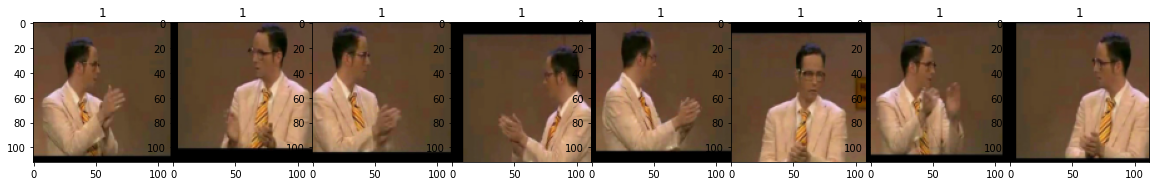

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0, hspace=0)
for i, im in enumerate(img[::2]):
  plt.subplot(1, 8, i+1)
  plt.imshow(denormalize(im, mean, std))
  plt.title(label)

In [ ]:
img, label = test_ds[34]
img.shape, label, torch.min(img), torch.max(img)

(torch.Size([16, 3, 112, 112]), 2, tensor(-1.8952), tensor(2.8736))

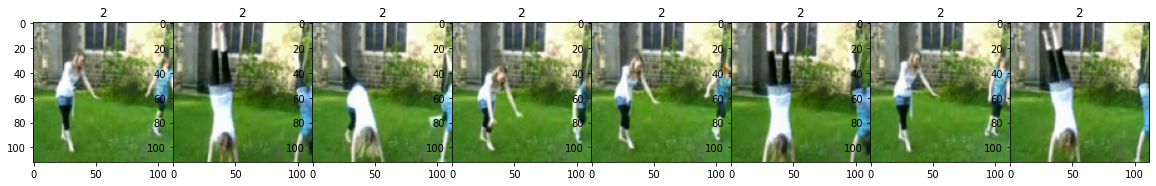

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0, hspace=0)
for i, im in enumerate(img[::2]):
  plt.subplot(1, 8, i+1)
  plt.imshow(denormalize(im, mean, std))
  plt.title(label)

In [ ]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    img_batch = []
    for im in imgs_batch:
      if type(im) != 'List':
        img_batch.append(img)
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, img_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(img_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

In [ ]:
def collate_fn_rnn(batch):
  imgs_batch, label_batch = list(zip(*batch))
  img_batch = []
  for im in imgs_batch:
    if type(im) != 'List':
      img_batch.append(img)
  label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, img_batch) if len(imgs)>0]
  imgs_tensor = torch.stack(img_batch)
  labels_tensor = torch.stack(label_batch)
  return imgs_tensor, labels_tensor

In [ ]:
batch_size=1
collate_fn = collate_fn_rnn if model_type == 'rnn' else collate_fn_r3d_18

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=2*batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
for (x, y), (z, p) in zip(train_dl, test_dl):
  print(x.shape, y.shape)
  print(z.shape, p.shape)
  break

torch.Size([1, 3, 16, 112, 112]) torch.Size([1])
torch.Size([2, 3, 16, 112, 112]) torch.Size([2])


#Model

In [ ]:
class Resnet18Rnn(torch.nn.Module):
  def __init__(self, params_model):
    super(Resnet18Rnn, self).__init__()
    num_classes = params_model['num_classes']
    dr_rate = params_model['dr_rate']
    pretrained = params_model['pretrained']
    rnn_hidden_size = params_model['rnn_hidden_size']
    rnn_num_layers = params_model['rnn_num_layers']

    baseModel = torchvision.models.resnet18(pretrained=pretrained)
    num_features = baseModel.fc.in_features
    baseModel.fc = Identity()
    self.baseModel = baseModel
    self.dropout = torch.nn.Dropout(dr_rate)
    self.rnn = torch.nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
    self.fc1 = torch.nn.Linear(rnn_hidden_size, num_classes)
  
  def forward(self, x):
    b, ts, c, g, w = x.shape

    for i in range(ts):
      y = self.baseModel(x[:, i])
      if i == 0:
        out, (hn, cn) = self.rnn(y.unsqueeze(1))
      else:
        out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))

    out = self.dropout(out[:, -1])
    out = self.fc1(out)
    return out
  
class Identity(torch.nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  
  def forward(self, x):
    return x

In [ ]:
if model_type == 'rnn':
  params_model = {
      'num_classes': num_classes,
      'dr_rate': 0.1,
      'pretrained': True,
      'rnn_num_layers': 1,
      'rnn_hidden_size': 100}
  model = Resnet18Rnn(params_model)

else:
  model = torchvision.models.video.r3d_18(pretrained=True, progress=False)
  num_features = model.fc.in_features
  model.fc = torch.nn.Linear(num_features, num_classes)

In [ ]:
def get_model(num_classes, model_type="rnn"):
  if my_type == 'rnn':
    params_model = {
        'num_classes': num_classes,
        'dr_rate': 0.1,
        'pretrained': True,
        'rnn_num_layers': 1,
        'rnn_hidden_size': 100}
    model = Resnet18Rnn(params_model)
    
  else:
    model = torchvision.models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)   
  return model

In [ ]:
for my_type in (['rnn', '3dcnn']):
  with torch.no_grad():
    temp_model = get_model(5, my_type)

    if my_type == 'rnn':
      x = torch.zeros(1, 16, 3, h, w)
    else:
      x = torch.zeros(1, 3, 16, h, w)

    y = temp_model(x) 
    print(my_type, '===>', y.shape)

rnn ===> torch.Size([1, 5])
3dcnn ===> torch.Size([1, 5])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [ ]:
path2weights = '/content/models/'
os.makedirs(path2weights, exist_ok=True)

loss_func = torch.nn.CrossEntropyLoss(reduction='sum')
opt = torch.optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5, verbose=1)

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for x, y in tqdm.notebook.tqdm(dataset_dl):
        x=x.to(device)
        y=y.to(device)
        output=model(x)

        temp_loss = loss_func(output, y)
        with torch.no_grad():
            pred = output.argmax(dim=1, keepdim=True)
            metric_b=pred.eq(y.view_as(pred)).sum().item()
        
        if opt is not None:
            opt.zero_grad()
            temp_loss.backward()
            opt.step()
        
        running_loss+=temp_loss.item()        
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break

    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

In [ ]:
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={"train": [],"val": []}    
    metric_history={"train": [],"val": []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(num_epochs):
      current_lr = get_lr(opt)

      model.train()
      train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
      loss_history["train"].append(train_loss)
      metric_history["train"].append(train_metric)

      model.eval()
      with torch.no_grad():
          val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
      if val_loss < best_loss:
          best_loss = val_loss
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(model.state_dict(), path2weights)
          print("The Best Model has been saved")
      
      loss_history["val"].append(val_loss)
      metric_history["val"].append(val_metric)
      
      lr_scheduler.step(val_loss)
      if current_lr != get_lr(opt):
          print("Loading best model weights!")
          model.load_state_dict(best_model_wts)
      
      print(f"Train loss: {train_loss:.6f}, Val loss: {val_loss:.6f}, Train Accuracy: %{100*train_metric:.2f}, Val Accuracy: %{100*val_metric:.2f}")
      
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
params_train = {
    'num_epochs': 20,
    'optimizer': opt,
    'loss_func': loss_func,
    'train_dl': train_dl,
    'val_dl': test_dl,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': f'{path2weights}weights{model_type}.pt'
}

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

The Best Model has been saved
Train loss: 1.599242, Val loss: 1.565869, Train Accuracy: %31.88, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

The Best Model has been saved
Train loss: 1.566773, Val loss: 1.559904, Train Accuracy: %32.69, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.575875, Val loss: 1.571638, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.571737, Val loss: 1.566108, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.570094, Val loss: 1.564744, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.572020, Val loss: 1.566075, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.572478, Val loss: 1.571777, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch     8: reducing learning rate of group 0 to 1.5000e-05.
Loading best model weights!
Train loss: 1.572961, Val loss: 1.562142, Train Accuracy: %33.17, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.571836, Val loss: 1.566257, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.567228, Val loss: 1.568847, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.563528, Val loss: 1.564445, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.567017, Val loss: 1.563018, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.565631, Val loss: 1.561740, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch    14: reducing learning rate of group 0 to 7.5000e-06.
Loading best model weights!
Train loss: 1.565030, Val loss: 1.561264, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.564052, Val loss: 1.563788, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

The Best Model has been saved
Train loss: 1.563847, Val loss: 1.559519, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.560532, Val loss: 1.564780, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.562112, Val loss: 1.559967, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.560401, Val loss: 1.561788, Train Accuracy: %33.82, Val Accuracy: %33.33


  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Train loss: 1.562349, Val loss: 1.559769, Train Accuracy: %33.82, Val Accuracy: %33.33


In [ ]:
def plot_hist(hist, name='Loss'):
  num_epochs= len(hist["train"])
  plt.title(name)
  plt.plot(range(1,num_epochs+1),hist["train"],label="train")
  plt.plot(range(1,num_epochs+1),hist["val"],label="val")
  plt.ylabel(name)
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

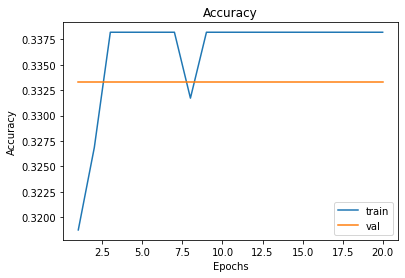

In [ ]:
plot_hist(metric_hist, 'Accuracy')

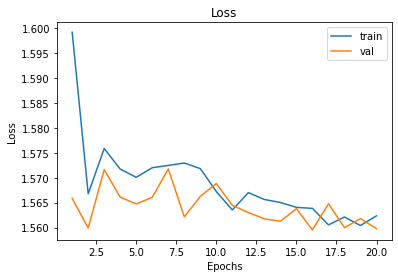

In [ ]:
plot_hist(loss_hist, 'Loss')

#Deploy the Model

In [ ]:
def transform_frames(frames, model_type="rnn"):
  if model_type == "rnn":
      h, w = 224, 224
      mean = [0.485, 0.456, 0.406]
      std = [0.229, 0.224, 0.225]
  else:
      h, w = 112, 112
      mean = [0.43216, 0.394666, 0.37645]
      std = [0.22803, 0.22145, 0.216989]

  test_transformer = torchvision.transforms.Compose([
              torchvision.transforms.Resize((h,w)),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(mean, std)]) 

  frames_tr = []
  for frame in frames:
      frame = PIL.Image.fromarray(frame)
      frame_tr = test_transformer(frame)
      frames_tr.append(frame_tr)
  imgs_tensor = torch.stack(frames_tr)    

  if model_type=="3dcnn":
      imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
  imgs_tensor = imgs_tensor.unsqueeze(0)
  return imgs_tensor

In [ ]:
def get_model(num_classes, model_type="rnn"):
  if my_type == 'rnn':
    params_model = {
        'num_classes': num_classes,
        'dr_rate': 0.1,
        'pretrained': True,
        'rnn_num_layers': 1,
        'rnn_hidden_size': 100}
    model = Resnet18Rnn(params_model)
    
  else:
    model = torchvision.models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)   
  return model

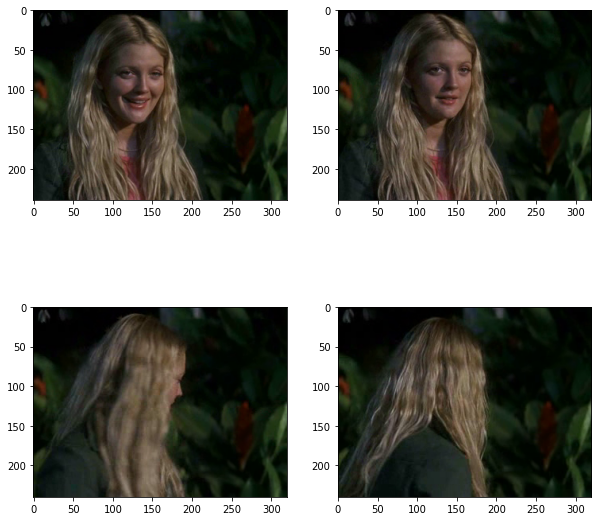

In [ ]:
model_type = "3dcnn"
model = get_model(model_type=model_type, num_classes = 5)


model.eval();
path2weights = "/content/models/weights"+model_type+".pt"
model.load_state_dict(torch.load(path2weights))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

 
path2vido = "/content/data/hmdb51_org/turn/50_FIRST_DATES_turn_h_nm_np1_fr_goo_23.avi"
frames, v_len = get_frames(path2vido, n_frames=16)

plt.figure(figsize=(10,10))
for i,img in enumerate(frames[::4]):
    plt.subplot(2,2,i+1)
    plt.imshow(img)

In [ ]:
imgs_tensor = transform_frames(frames, model_type)
print(imgs_tensor.shape, torch.min(imgs_tensor), torch.max(imgs_tensor))
with torch.no_grad():
    out = model(imgs_tensor.to(device)).cpu()
    print(out.shape)
    pred = torch.argmax(out).item()
    print(pred)

torch.Size([1, 3, 16, 112, 112]) tensor(-1.8952) tensor(2.1507)
torch.Size([1, 5])
3
